In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cdecimal as dec

                     date  drybulb_C  dewpoint_C  occupancy      Qrad
index                                                                
0     2013-01-01 00:00:00       -2.1        -3.1      0.000  0.000000
1     2013-01-01 01:00:00       -2.7        -3.4      0.000  0.000000
2     2013-01-01 02:00:00       -2.3        -3.4      0.000  0.000000
3     2013-01-01 03:00:00       -1.3        -3.7      0.000  0.000000
4     2013-01-01 04:00:00       -0.8        -2.6      0.000  0.000000
5     2013-01-01 05:00:00       -0.1        -2.5      0.000  0.000000
6     2013-01-01 06:00:00        0.7        -2.1      0.000  0.000000
7     2013-01-01 07:00:00        1.6        -1.9      0.016  0.000000
8     2013-01-01 08:00:00        3.9        -1.7      0.032  0.150141
9     2013-01-01 09:00:00        5.1        -1.0      0.032  0.279895
10    2013-01-01 10:00:00        6.0        -1.3      0.032  0.378627
11    2013-01-01 11:00:00        6.3        -0.3      0.048  0.238779
12    2013-01-01 12:

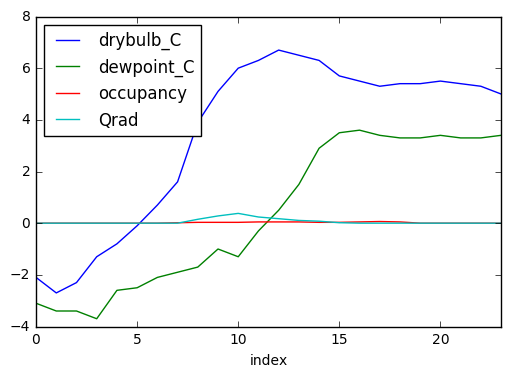

In [12]:
#epw_reader adapted from https://github.com/architecture-building-systems/CEAforArcGIS/blob/master/cea/utilities/epwreader.py

epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                   'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2',
                   'dirnorrad_Whm2', 'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux','difhorillum_lux',
                   'zenlum_lux', 'winddir_deg', 'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km',
                   'ceiling_hgt_m', 'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths',
                   'snowdepth_cm', 'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']

weather_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\Zurich-Kloten_2013.epw'
occupancy_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\Occupancy_COM.csv'
radiation_path = r'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\radiation_Building_Zh.csv'

    
def get_full_date(weather_path,month,day):
    year = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels)['year']
    return pd.datetime(year[1],month,day)

def get_epw_year(weather_path):
    df = epw_reader(weather_path=weather_path)  
    df['date'] = pd.to_datetime(df['date'])
    return df['year'][0]
    
def epw_reader(weather_path):
    start = get_full_date(weather_path,1,1)
    result = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1)
    result['dayofyear'] = pd.date_range(start, periods=8760, freq='H').dayofyear  
    result['date'] = pd.date_range(start, periods=8760, freq='H')
    #esult['ratio_diffhout'] = result['difhorrad_Whm2']/result['glohorrad_Whm2']
    result['index'] = result.index
    return result

def get_occupancy(occupancy_path):
    df = pd.read_csv(occupancy_path, header=0,keep_default_na=False)[:8760]
    occupancy = pd.DataFrame({'occupancy':df['People']})  
    return occupancy

def get_epw_data(field = []): 
    series = epw_reader(weather_path=weather_path) 
    field.insert(0,'date')
    series = series[field]
    return series 

def get_date_range(start,end,series):
    series['index'] = series.index
    series = series.set_index(['date'],drop=False)  
    series = series[start:end]
    series = series.set_index(['index']) 
    return series

def get_radiation(radiation_path):
    df = pd.read_csv(radiation_path,header=None)
    df = df.T
    return df

def resample(dataframe,dt):
    if dt > 1:
        resample_value = str(dt)+'H'
    elif dt < 1:
        resample_value = str(int(dt*60))+'Min'     
    elif dt == 1:
        resample_value = '1H'
    dataframe = dataframe.set_index(['date']) #use date as index. this allows for time resampling
    dataframe = dataframe.resample(resample_value).mean()  
    dataframe = dataframe.interpolate()   
    dataframe = dataframe.reset_index(drop=False)     
    return dataframe

#================TESTING====================
year = get_epw_year(weather_path)
start = '01/01/%i 00:00:00' %year
start = pd.to_datetime(start)
end =  '01/01/%i 23:00:00' %year
end = pd.to_datetime(end)

occ = get_occupancy(occupancy_path)
occ = occ.astype('float64', raise_on_error = False) #Convert occupancy values to float
Qrad = get_radiation(radiation_path)

data = get_epw_data(['drybulb_C','dewpoint_C'])
data['occupancy'] = occ
data['Qrad'] = Qrad
data = get_date_range(start,end,data)

print data
data.plot()


In [15]:
"""
Input data
Adapted from https://github.com/architecture-building-systems/RC_BuildingSimulator/blob/master/simulator/BuildingProperties.py
"""

class building(object): 
    def __init__(self, 
                 R_env = 42,   #resistance of envelope
                 Cm    = 2.07   #capacitance of envelope
                ):
        #Single Capacitance Model Parameters
        self.Cm=Cm #[kWh/K] Room Capacitance. Default based of Madsen2011
        self.R_env=R_env #[K/kW] Wall resistance to outside air. Default based off glass having a Uvalue of 1.978W/m2K, 12m2 facade glass
        
"""
main
"""


#Simulation parameters
year = get_epw_year(weather_path)
start = '31/01/%i' %year
end =  '01/01/%i' %year


#import data
data = get_epw_data(['drybulb_C'])
temperatures = get_date_range(start,end,data)
T_out = temperatures['drybulb_C']
box = building(Cm = 2.07,R_env = 42)

#initialize conditions
dt = 0.3
temperatures = resample(temperatures,dt)
T_out = temperatures['drybulb_C']
steps = len(temperatures.index)

T_in_init = 20 #initial internal temperature
Data_Tin = []

#no heating or cooling, no internal gains, no external gains.
occ = get_occupancy(occupancy_path)
occ = occ.astype('float64', raise_on_error = False) #Convert occupancy values to float

#Qint = something * occ

Qrad = get_radiation(radiation_path)


#differential equation parameters


#Forward Euler discretization
def FE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]-T_in)/(box.R_env*box.Cm))*dt + T_in
        Data_Tin.append(T_in)
    return Data_Tin

#Backward Euler discretization
def BE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]*dt)+(box.R_env*box.Cm*T_in))/(box.R_env*box.Cm + dt)
        Data_Tin.append(T_in)
    return Data_Tin

#Crank Nicholson discretization
def CN(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):     
        T_in = ((2*T_out[i]*dt)+T_in*(2*box.R_env*box.Cm - dt))/(2*box.R_env*box.Cm +dt)
        Data_Tin.append(T_in)            
    return Data_Tin

"""
x= pd.Series(FE(T_in_init,dt))
x.plot()
plt.show
print x
"""



temperatures['T_in-FE'] = pd.Series(FE(T_in_init,dt))
temperatures['T_in-BE'] = pd.Series(BE(T_in_init,dt))
temperatures['T_in-CN'] = pd.Series(CN(T_in_init,dt))

temperatures = temperatures.set_index(['date'])


temperatures.plot()
plt.show()
print temperatures

TypeError: Empty 'DataFrame': no numeric data to plot

Abbreviations

T_out: External temperature in C extracted from an EPW weather file

T_in: Calculated internal temperature

R_env: Resistance of the envelope. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

R_infl: Equivalent resistance due to infiltration. This is calculated within BuildingProperties.py

R_vent: Equivalent resistance due to ventelation. A variable resistance calculated by the setVentelation method in within the Building class of BuildingProperties.py

Cm: Capacitance of the room. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

Q_Heat: Heat energy supplied or removed by the heater or cooler. This is determined through a controller based on the temperature set points

Q_rad: Heat energy to the sun. Hourly radiation data through the windows must be determined in advance and read through the read_transmittedR funtion of input_data.py

Q_gains: Internal heat gains of people. Determined through the occupancy profile which is read in through the read_occupancy function of input_data.py